In [1]:
%matplotlib inline
from imports import *

## Discussion materials

### Load Debian packages

In [4]:
debian_packages = pd.read_csv('../../data/prepared_data/debian_packages.csv',
                             usecols=['package','version','archive','date'])
debian_packages.drop_duplicates(inplace=True)
for col in debian_packages.columns:
    debian_packages[col] = debian_packages[col].apply(str)
debian_packages.shape

(954495, 4)

In [5]:
packages = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                      usecols=['package'], dtype=object)
packages.shape

(46272487, 1)

In [6]:
mask = debian_packages.package.isin(packages.package)
debian_packages = debian_packages[mask]
debian_packages.shape

(203808, 4)

In [7]:
debian_packages = debian_packages.query('archive != "bullseye"').copy()
release_map={'jessie':'Oldstable',
             'stretch':'Stable',
             'buster':'Testing'}
type_map={'o':'official',
          'c':'community'}
debian_packages = debian_packages.replace({'archive': release_map})

In [ ]:
debian_packages.sort_values('date', inplace=True)

## We check the time needed before a new package version is released

In [9]:
df_new = (debian_packages
          .drop('version', axis=1)
          .rename(columns={'date':'latest',})
          .groupby(['package','archive',])
          .last()
          .merge(debian_packages
                 .drop('version', axis=1)
                 .rename(columns={'date':'first'})
                 .groupby(['package','archive'])
                 .first(),
                left_index=True,
                right_index = True,
                how='left')
          .merge(debian_packages
                 .drop('date', axis=1)
                 .groupby(['package','archive'])
                 .count(),
                left_index=True,
                right_index = True,
                how='left')
          .reset_index()
         )

In [10]:
for x in ['first','latest']:
    df_new[x] = pd.to_datetime(df_new[x])

In [11]:
df_new['days'] = df_new.apply(lambda d: (d['latest'] - d['first']).days, axis=1)

In [12]:
df_new['frequence'] = df_new['days']/df_new['version']

([<matplotlib.axis.YTick at 0x7fece0f51400>,
 <a list of 6 Text yticklabel objects>)

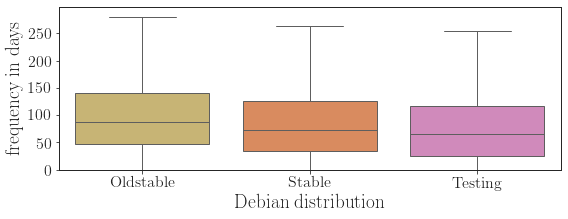

In [13]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,3)
order = ['Oldstable','Stable','Testing']
ax = sns.boxplot(x="archive", 
                 y="frequence", 
                 order = order,
                 data=df_new, 
                 palette=[colors[r] for r in order] , 
                 linewidth=1,
                 showfliers= False)
ax.set(
    xlabel='Debian distribution',
    ylabel='frequency in days',
    ylim=(0,299)
)
plt.yticks(pd.np.arange(0, 300, 50))

## We check when "latest" package version were released

In [14]:
debian_packages = pd.read_csv('../../data/prepared_data/debian_packages.csv',
                             usecols=['package','version','archive','date'])
debian_packages.drop_duplicates(inplace=True)
for col in debian_packages.columns:
    debian_packages[col] = debian_packages[col].apply(str)
debian_packages.shape

(954495, 4)

In [15]:

debian_packages = debian_packages.query('archive != "bullseye"').copy()
release_map={'jessie':'Oldstable',
             'stretch':'Stable',
             'buster':'Testing'}
type_map={'o':'official',
          'c':'community'}
debian_packages = debian_packages.replace({'archive': release_map})

In [16]:
debian_packages.sort_values('date', inplace=True)

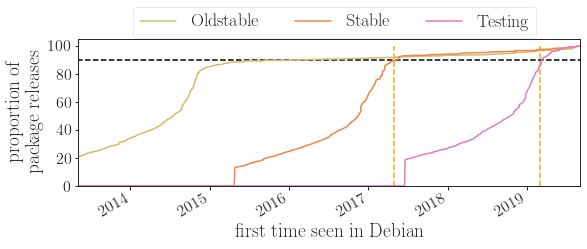

In [17]:
dff = (debian_packages
            .drop('version', axis=1)
            .rename(columns={'date':'latest',})
            .groupby(['package','archive',])
            .last()
            .reset_index()
            .groupby(['latest','archive'])
            .count()
            .loc[:,['package']]
            .reset_index())

dff=(dff.
    pivot(index='latest', columns='archive', values='package').
    fillna(0).
    reset_index())
dff['latest'] = pd.to_datetime(dff['latest'])

dff.set_index('latest', inplace=True)
for x in dff:
    dff[x]=dff[x].cumsum()
    maxx=dff[x].values.max()
    dff[x]=dff[x]*100/maxx
ax=dff.plot( color=[colors[r] for r in order])#, ax=axes[int(i/2)][j], label=type)    
ax.hlines(90, pd.to_datetime('2013-05-01'), pd.to_datetime('2019-09-01'), colors='black', linestyles='dashed', alpha=1)

ax.set_ylim(0,)
ax.set_ylabel('proportion of \npackage releases')
ax.set_xlabel('first time seen in Debian')
ax.figure.set_size_inches(9,3)
plt.tick_params(axis='both', which='major', labelsize=16, width=1)
plt.legend(bbox_to_anchor=(0.93, 1.28), ncol=3, prop={'size': 18})
plt.yticks(pd.np.arange(0, 101, 20))
ax.vlines(pd.to_datetime('2017-05-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2019-03-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)


# Let's check how many Dockerfiles make use of the command "apt upgrade"

In [2]:
commands = pd.read_csv('../../data/for_analysis/commands_all_images.csv')
commands.dropna(inplace=True)

In [11]:
s = (commands[commands.command.str.contains('apt upgrade')].image.unique().tolist()
     + commands[commands.command.str.contains('apt-get upgrade')].image.unique().tolist()
     + commands[commands.command.str.contains('apt-get -y upgrade')].image.unique().tolist()
     + commands[commands.command.str.contains('apt -y upgrade')].image.unique().tolist())
print(len(set(s)),'which means a proportion of', '{:.1f}'.format(len(set(s))*100/commands.image.unique().size),'of all images')

6507 which means a proportion of 6.2 of all images
